### Neural Networks
In this section we will use Neural Networks to carry out classification on the natural gas data set. A neural network "learns" by solving an optimization problem to choose a set of parameters that minimizes an error function, which is typically a squared error loss. The neural network will attempt to find a "sweet spot": while the model is highly non-linear, its particular functional form allows for a computationally slick fitting procedure called "backpropogation". All we will do here is to "learn" by switching between computing the error using the training data and updating the weights by calculating the gradient of the error function. 

Let us write a class for NeuralNetworks, and we will then apply it to performing classification.

In [1]:
#Neural Network Class 
class Neural_Net:

    #constructor initializes a new neural network with randomly selected weights and pre-specified height, and number of neurons per layer
    def __init__(self,non,height):
        #list to store the number of neurons in each layer of the network
        self.num_of_neurons = non
        #height of the network
        self.L = height
        #list to store number of weights in each layer of the network, indexed by layer, output neuron, input neuron
        self.weights = numpy.zeros(shape=(10,10,10))
        #delta_matrix: stores the gradient that is used in backpropagation
        self.deltas = numpy.zeros(shape=(10,10))
        #matrix that stores thresholded signals
        self.signals = numpy.zeros(shape=(10,10))
        #(tunable) learning_rate used in backpropagation
        self.learning_rate = .001
        #initialize weights to be between -2 and 2
        for i in range(1,self.L+1):
            for j in range(1,self.num_of_neurons[i]+1):
                for k in range(self.num_of_neurons[i-1]+1):
                    self.weights[i][j][k] = random.random()*4-2

    #forward_pass computes the output of the neural network given an input
    def forward_pass(self,x):
        #(for convenience, we index neurons starting at 1 instead of zero)
        self.signals[0][0] = -1
        for i in range(1,self.num_of_neurons[0]+1):
            self.signals[0][i] = x[i-1]
        for i in range(1,self.L+1):
            self.signals[i][0] = -1
            for j in range(1,self.num_of_neurons[i]+1):
                self.signals[i][j] = self.compute_signal(i,j)
        return self.signals[self.L][1]

    #tune_weights performs the backpropagation algorithm given a training example as input
    def tune_weights(self,y):
        self.deltas[self.L][1] = 2*(self.signals[self.L][1]-y)*(1-math.pow(self.signals[self.L][1],2))
        for i in range(self.L-1,0,-1):
            for j in range(1,self.num_of_neurons[i]+1):
                self.deltas[i][j] = self.compute_delta(i,j)
        for i in range(1,self.L+1):
            for j in range(1,self.num_of_neurons[i]+1):
                for k in range(self.num_of_neurons[i-1]+1):
                    self.weights[i][j][k] = self.weights[i][j][k]-self.learning_rate*self.signals[i-1][k]*self.deltas[i][j]

    #compute_signal: computes the delta for a given neuron at a given level
    def compute_signal(self,level,neuron):
        s = 0
        for i in range(self.num_of_neurons[level-1]+1):
            s += self.weights[level][neuron][i]*self.signals[level-1][i]
        return self.g(s)
    
    #compute_delta: computes the signal s for a given neuron at a given level
    def compute_delta(self,level,neuron):
        s = 0
        for j in range(1,self.num_of_neurons[level+1]+1):
            s += self.weights[level+1][j][neuron]*self.deltas[level+1][j]
        return (1-math.pow(self.signals[level][neuron],2))*s

    #soft threshold function
    def g(self,s):
        return (math.exp(s)-math.exp(-s))/(math.exp(s)+math.exp(-s))

In [4]:
%matplotlib inline
import pandas as pd
import numpy
import math
import scipy
import random
import brewer2mpl
import matplotlib.pyplot as plt

Now let's train a neural network and see how well it performs on the test and training sets from our natural gas dataset epoch by epoch. We instantiate a neural network with one hidden layer with four neurons, and a learning rate of .001. The learning rate is how much we scale the gradient in "walking" the parameter space.

Let us load our data set

In [5]:
#load the data for analysis
dflog=pd.read_excel("data/DataSet_GasPrice_ Outlier_Removed.xlsx")
dflog.head()

,Days,Date,AveCoalPrice,OilPrice,GrossGasProd,TotGasCons,GasPrice,Weather,WSTAT,GasPriceStatus
0,245,2008-12-31,57.22,41.12,2227.028,2399.702,5.82,WINTER,1,HIGH
1,276,2009-01-31,54.37,41.71,2251.938,2729.715,5.24,WINTER,1,HIGH
2,304,2009-02-28,52.30,39.09,2074.167,2332.539,4.52,WINTER,1,HIGH
3,335,2009-03-31,44.34,47.94,2262.488,2170.709,3.96,WINTER,1,HIGH
4,365,2009-04-30,41.92,49.65,2147.856,1741.293,3.50,SPRING,0,HIGH


In [6]:
#Change the columns name to create attributes and features
dflog.columns = ['DAYS', 'DATE', 'COALP', 'OILP', 'GPROD', 'GCONS', 'GASP', 'WEATH', 'WSTAT', 'GPSTAT']
dflog.head()

,DAYS,DATE,COALP,OILP,GPROD,GCONS,GASP,WEATH,WSTAT,GPSTAT
0,245,2008-12-31,57.22,41.12,2227.028,2399.702,5.82,WINTER,1,HIGH
1,276,2009-01-31,54.37,41.71,2251.938,2729.715,5.24,WINTER,1,HIGH
2,304,2009-02-28,52.30,39.09,2074.167,2332.539,4.52,WINTER,1,HIGH
3,335,2009-03-31,44.34,47.94,2262.488,2170.709,3.96,WINTER,1,HIGH
4,365,2009-04-30,41.92,49.65,2147.856,1741.293,3.50,SPRING,0,HIGH


In [7]:
# Split data into training set and testing set
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['GASP','GCONS']].values, 
                                              (dflog.WSTAT == 0).values,random_state=5)

In [73]:
Xlr.shape

(78, 2)

In [75]:
Xtestlr.shape

(26, 2)

In [109]:
#read in the train and test dat, assuming csv format
training = Xlr
testing = Xtestlr

#specify the number of neurons in each layer
num_of_neurons = [1]

#initialize a new neural network
network = Neural_Net(num_of_neurons,0)

#store the training error and test error during each epoch
training_error = 0
test_error = 0

#store the training and test error for all epochs
train = numpy.zeros(shape = (26))
test = numpy.zeros(shape = (26))

for epoch in range(26):
    training_error = 0
    test_error = 0
    #compute the test errors
    for j in range(26):
        test_error = test_error+math.pow(network.forward_pass(testing[j]) - testing[j][1], 2)
    #compute the training errors, SEQUENTIALLY. In other words, we perform backpropagation for *every* example
    #instead of all at once. 
    for i in range(78):
        training_error = training_error+math.pow(network.forward_pass(training[i])- training[i][1], 2)
        network.tune_weights(training[i][0])   
    training_error = training_error/78
    test_error = test_error/26
    train[epoch] = training_error
    test[epoch]  = test_error

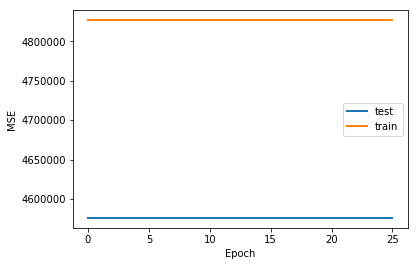

In [110]:
fig, ax = plt.subplots()
ax.plot(numpy.arange(26), test, lw=2, label = 'test')
ax.plot(numpy.arange(26), train, lw=2, label = 'train')
ax.legend(loc=0)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')